In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from datetime import datetime
from numba import jit
import scipy.optimize as opt
from lmfit.models import GaussianModel, ConstantModel

import tables
import os

test_input.h5 (File) ''
Last modif.: 'Sun Sep 30 15:01:08 2018'
Object Tree: 
/ (RootGroup) ''
/EventData (Table(63734,), shuffle, zlib(1)) ''
/RawData (EArray(63734, 4096), shuffle, zlib(1)) ''

63734


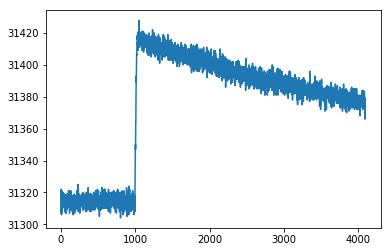

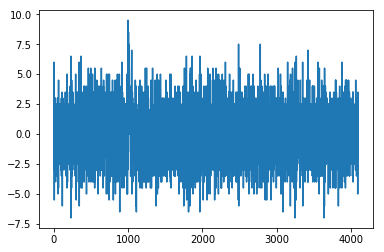

In [2]:
h5file = tables.open_file("data/test_input.h5", driver="H5FD_CORE")
print(h5file)
data = h5file.root.RawData
EventData = h5file.root.EventData
print(len(EventData))



plt.figure()
plt.plot(data[100,:])
plt.figure()
plt.plot(np.gradient(data[100,:]))
plt.show()

In [3]:
# Find pulses that triggered multiple times and delete them
i_pileup = 0
j_pileup = 0
pileup_args = np.array([])
EventDataArray = np.array(EventData)

for x in range(len(EventData)):
    if int(EventData[x][3])>1:
        pileup_args = np.append(pileup_args,i_pileup)
        j_pileup = j_pileup+1  
    i_pileup = i_pileup+1

print(data)
print(len(pileup_args))

data = np.delete(data[:], pileup_args, 0)
    
print('deleted ', len(pileup_args),' signals due to pile up')
#print(len(data2))

/RawData (EArray(63734, 4096), shuffle, zlib(1)) ''
1248


/Users/DragonKnight/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:16: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  app.launch_new_instance()


deleted  1248  signals due to pile up


In [4]:
@jit(parallel = True)
def baseLineReduction(mysignal):
    avgNoise = np.mean(mysignal[0:1000])
    return mysignal-avgNoise

In [5]:
@jit(parallel = True)
def TrapFilter(mysignal,tau,k,m):
    signalOnly = baseLineReduction(mysignal) 
    M = tau
    Acc1=0.0
    Acc2=0.0
    i=0
    zeros = np.zeros(2*k+m)
    extSignalOnly=np.append(zeros,signalOnly)
    final = np.zeros(len(signalOnly))
    for i in range(len(signalOnly)):
        parta = extSignalOnly[i+(2*k+m)] - extSignalOnly[i-k+(2*k+m)]
        partb = extSignalOnly[i-2*k-m+(2*k+m)] - extSignalOnly[i-k-m+(2*k+m)]
        partc = parta + partb
        Acc1 = Acc1+partc
        partd = partc*M+Acc1
        Acc2 = Acc2 + partd
        final[i] = Acc2
        i=i+1
    
    normFinal = np.array(final)
    return normFinal

In [6]:
rows = len(data[:,0])
print(rows)
cols = len(data[0,:])
mysignals = np.zeros((rows,cols))

@jit(parallel = True)
def makesignals(raw_data):
    for j in range(0,rows):
        mysignals[j] = data[j,:]
    return mysignals

startTime = datetime.now()

mysignals = makesignals(data)

print(datetime.now() - startTime)

62486
0:00:01.901023


In [7]:
@jit(parallel = True)
def func(x, a, b):
    return a * np.exp(-b * x)

In [8]:
#startTime = datetime.now()
#events = len(mysignals)
#cols = len(data[0,:])
#trap_out = np.zeros((events,cols))
#tau = np.zeros(events)
#for j in range(0,events):
#    signalOnly = baseLineReduction(mysignals[j])
#    popt, pcov = curve_fit(func, range(0,len(signalOnly)-1115), signalOnly[1115:])
#    tau[j] = 1.0/popt[1]
#    print(j)
#print('Average Tau across all signals',np.mean(tau))
#print(datetime.now() - startTime)

In [9]:
@jit(parallel = True)
def eventsProcess(mysignals, events, cols,tau,k,m):
#    tau = np.zeros(events)
    startTime = datetime.now()
    trap_out = np.zeros((events,cols))
    for j in range(0,events):
        trap_out[j] = TrapFilter(mysignals[j,:],tau,k,m)
    print(datetime.now() - startTime)
    return trap_out

In [49]:
@jit(parallel = True)
def gauss(x, a, u, sig):
    return a*np.exp(-(x-u)**2.0/(2.0*sig**2.0))

@jit(parallel = True)
def FWHM(counts,lower_bound,upper_bound):
    X = range(lower_bound, upper_bound)
    Y = counts[lower_bound:upper_bound]
    # Fit a guassian
    mean = sum(X * Y) / sum(Y)
    sigma = np.sqrt(sum(Y * (X - mean)**2) / sum(Y))
#    pi = [max(Y),mean,sigma]
#    popt, pcov = curve_fit(gauss, X, Y, p0=pi)
#    print(popt)
#    fit_a, fit_mu, fit_stdev = popt
    # fit guassian using other method
    model = GaussianModel(prefix='peak_') + ConstantModel()
    # make a model that is a Gaussian + a constant:
    model = GaussianModel(prefix='peak_') + ConstantModel()

    # make parameters with starting values:
    params = model.make_params(c=1.0, peak_center=mean, peak_sigma=sigma, peak_amplitude=max(Y))
    # run fit
    result = model.fit(Y, params, x=X)
    print('fwhm: 'result.params['peak_fwhm'].value, 'centroid: ', result.params['peak_center'].value)
    # find FWHM
#    fwhm = 2*np.sqrt(2*np.log(2))*np.abs(fit_stdev)
#    cent = fit_mu
    return result.params['peak_fwhm'].value, result.params['peak_center'].value

In [20]:
@jit(parallel = True)
def TraptoCounts(trap_out,k,M):
    counts = []
    for j in range(0,len(trap_out)):
        counts = np.append(counts,np.amax(trap_out[j]))
    counts2 = np.trim_zeros(counts)
    counts2 = counts2/((M+1)*k)
    counts3 = counts2[(counts2>0) & (counts2<1e3)]
    yhist, bins_hist = np.histogram(counts3,bins=8196)
    return yhist

# convert Traps to Counts and then do FWHM on the Peak
#plt.figure()
#nhist, bins, ign = plt.hist(counts3,bins=8196)

In [50]:
print(len(mysignals))
events = len(mysignals)
tau = 5810.79
@jit(parallel = True)
def find_k(mysignals, events, cols, tau, m):
    out_f = []
    out_c = []
    for k in range(200,1200,20):
        processedEvents = eventsProcess(mysignals,events,cols,tau,k,m)
        counts = TraptoCounts(processedEvents,k,tau)
        out_fwhm, out_cent = FWHM(counts,6000,6500)
        out_f.append(out_fwhm)
        out_c.append(out_cent)
        print('k=',k)
    return out_f, out_c

startTime = datetime.now()
#find k first
FWHM_k, cent_k = find_k(mysignals,events,cols,tau,30)

print(datetime.now() - startTime)

62486
0:00:12.168182
18.041682347990854
k= 200
0:00:12.550894
18.19703268063452
k= 220
0:00:12.324924
18.468782499851883
k= 240
0:00:12.061208
19.003112919145348
k= 260
0:00:12.151931
19.069040523246265
k= 280
0:00:11.794603
19.477936958006108
k= 300
0:00:13.590477
19.817138057766122
k= 320
0:00:12.301918
20.39172761024603
k= 340
0:00:12.593756
20.83030459931396
k= 360
0:00:14.026307
21.355261848560705
k= 380
0:00:11.553209
21.91533216117616
k= 400
0:00:13.018030
22.354425693622826
k= 420
0:00:14.586787
22.822876089209235
k= 440
0:00:12.794144
23.27905632710479
k= 460
0:00:11.884163
23.725739008396506
k= 480
0:00:11.929319
24.02079050017653
k= 500
0:00:12.696152
24.379162184938256
k= 520
0:00:13.531686
24.53234912043635
k= 540
0:00:13.647995
24.912711541574982
k= 560
0:00:12.110060
25.06643022719455
k= 580
0:00:11.770566
25.322134030108064
k= 600
0:00:13.253568
25.48704622359143
k= 620
0:00:12.517483
25.68072399334054
k= 640
0:00:12.189228
25.81256031311688
k= 660
0:00:13.384805
25.880

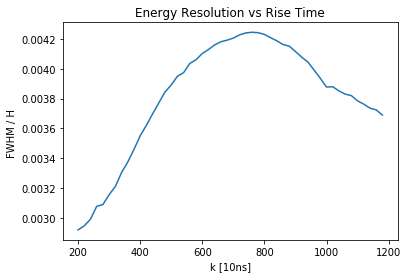

In [56]:
plt.figure()
fwhm_1 = np.array(FWHM_k)
h = np.array(cent_k)
fwhm_f = fwhm_1/h
plt.plot(range(200,1200,20),fwhm_f)
plt.xlabel('k [10ns]')
plt.ylabel('FWHM / H ')
plt.title('Energy Resolution vs Rise Time')
plt.savefig('images/RvsK.png')